In [2]:
import SimPEG as simpeg
from scipy.constants import mu_0
def omega(freq):
    """Change frequency to angular frequency, omega"""
    return 2.*np.pi*freq

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
np.sum(100*np.cumprod(np.ones(5)*1.6))

   

2529.536000000001

In [5]:
# M = Mesh.TensorMesh([[(100.,32)],[(100.,34)],[(100.,18)]], x0='CCC')
# M = simpeg.Mesh.TensorMesh([[(100,5,-1.5),(100.,5),(100,5,1.5)],[(100,5,-1.5),(100.,5),(100,5,1.5)],[(100,5,-1.5),(100.,10),(100,5,1.5)]], x0=['C','C','C'])
M = simpeg.Mesh.TensorMesh([[(1000,6,-1.5),(1000.,6),(1000,6,1.5)],[(1000,6,-1.5),(1000.,2),(1000,6,1.5)],[(1000,10,-1.3),(1000.,2),(1000,10,1.3)]], x0=['C','C','C'])# Setup the model


In [6]:
print M.vectorNz

[ -5.64053465e+04  -4.26194973e+04  -3.20149979e+04  -2.38576907e+04
  -1.75828390e+04  -1.27560300e+04  -9.04310000e+03  -6.18700000e+03
  -3.99000000e+03  -2.30000000e+03  -1.00000000e+03   7.27595761e-12
   1.00000000e+03   2.30000000e+03   3.99000000e+03   6.18700000e+03
   9.04310000e+03   1.27560300e+04   1.75828390e+04   2.38576907e+04
   3.20149979e+04   4.26194973e+04   5.64053465e+04]


<matplotlib.colorbar.Colorbar instance at 0x7fda385d5c20>

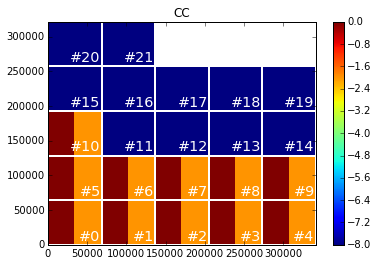

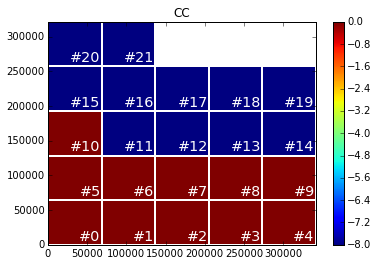

In [7]:
# Setup the model
# conds = [1,1e-2]
# elev = 300
# sig = simpeg.Utils.ModelBuilder.defineBlock(M.gridCC,[-100000,-100000,-200],[100000,100000,0],conds)
# sig[M.gridCC[:,2]>elev] = 1e-8
# sig[M.gridCC[:,2]<-500] = 1e-1
# sig[M.gridCC[:,2]<-900] = 1e-2
elev=0
conds = [1,1e-2]
sig = np.ones(M.nC)*conds[0]
sig[M.gridCC[:,0]>0] = conds[1]
sig[M.gridCC[:,2]>elev] = 1e-8
# sigBG = np.zeros(M.nC) + conds[0]
# sigBG[M.gridCC[:,2]>0] = 1e-8
sigBG = np.ones(M.nC)*conds[0]
sigBG[M.gridCC[:,2]>elev] = 1e-8
colorbar(M.plotImage(log10(sig)))
colorbar(M.plotImage(log10(sigBG)))


In [8]:
# Get the mass matrix 
# The model
Msig = M.getEdgeInnerProduct(sig)
MsigBG = M.getEdgeInnerProduct(sigBG)
Mmu = M.getFaceInnerProduct(mu_0, invProp=True)

In [9]:
freq = 1.0
C = M.edgeCurl
A = C.T*Mmu*C - 1j*omega(freq)*Msig
ARH = -(C.T*Mmu*C - 1j*omega(freq)*MsigBG)

In [10]:
%%time
# Solve the systems for each polarization
sys.path.append('/media/gudni/ExtraDrive1/Codes/python/pymatsolver/')
from pymatsolver import MumpsSolver
Ainv = MumpsSolver(A)

CPU times: user 2.46 s, sys: 24 ms, total: 2.49 s
Wall time: 2.48 s


In [11]:
# Need to solve x and y polarizations of the source.
from simpegMT.Utils import get1DEfields
# Get a 1d solution for a halfspace background
mesh1d = simpeg.Mesh.TensorMesh([M.hz],np.array([M.x0[2]]))
e0_1d = get1DEfields(mesh1d,M.r(sigBG,'CC','CC','M')[0,0,:],freq,sourceAmp=None).conj()
# Setup the primary field (p) for the x (east) polarization (_px)
ex_px = np.zeros((M.vnEx),dtype=complex)
ey_px = np.zeros(M.nEy,dtype=complex)
ez_px = np.zeros(M.nEz,dtype=complex)
# Assign the source to ex_x
for i in arange(M.vnEx[0]):
    for j in arange(M.vnEx[1]):
        ex_px[i,j,:] = -e0_1d
ep_px = np.r_[simpeg.Utils.mkvc(ex_px),ey_px,ez_px]
rhs_px = ARH.dot(ep_px)

In [12]:
# Setup y (north) polarization (_y)
ex_py = np.zeros(M.nEx, dtype='complex128')
ey_py = np.zeros((M.vnEy), dtype='complex128')
ez_py = np.zeros(M.nEz, dtype='complex128')
# Assign the source to ey_y
for i in arange(M.vnEy[0]):
    for j in arange(M.vnEy[1]):
        ey_py[i,j,:] = e0_1d  
        
ep_py = np.r_[ex_py,simpeg.Utils.mkvc(ey_py),ez_py]
rhs_py = ARH.dot(ep_py)

We are using splu in scipy package. This is bit slow, but on the cluster you can use mumps, which might a lot faster. We can think about having better iterative solver. 

In [13]:
%%time
es_px = Ainv*rhs_px
es_py = Ainv*rhs_py

CPU times: user 42.8 ms, sys: 0 ns, total: 42.8 ms
Wall time: 43.6 ms


In [14]:
# Need to sum the ep and es to get the total field.
e_x = es_px #+ ep_px
e_y = es_py #+ ep_py

I want to visualize electrical field, which is a vector, so I average them on to cell center. Also I want to see current density ($\vec{j} = \sigma \vec{e}$).

In [15]:
Meinv = M.getEdgeInnerProduct(np.ones_like(sig), invMat=True)

In [16]:
j_x = Meinv*Msig*e_x
j_y = Meinv*Msig*e_x

In [17]:
e_x.shape

(18598,)

In [18]:
e_x_CC = M.aveE2CCV*e_x
e_y_CC = M.aveE2CCV*e_y
j_x_CC = M.aveE2CCV*j_x
j_y_CC = M.aveE2CCV*j_y
# j_x_CC = Utils.sdiag(np.r_[sig, sig, sig])*e_x_CC

Then use "plotSlice" function, to visualize 2D sections

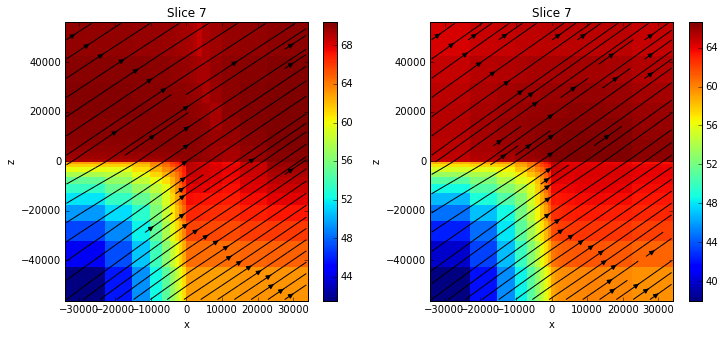

In [33]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
dat0 = M.plotSlice(np.log10(np.abs(e_x_CC)), vType='CCv', view='vec', streamOpts={'color': 'k'}, normal='Y', ax = ax[0])
cb0 = plt.colorbar(dat0[0], ax = ax[0])
dat1 = M.plotSlice(np.log10(np.abs(e_y_CC)), vType='CCv', view='vec', streamOpts={'color': 'k'}, normal='Y', ax = ax[1])
cb1 = plt.colorbar(dat1[0], ax = ax[1])

Is it reasonable?: Based on that you put resistive target that makes sense to me; current does not want to flow on resistive target so they just do roundabout:). And see air interface. It is continuous on current but not on electric field, which looks reasonable. 

In [20]:
# Calculate the data
rx_x, rx_y = np.meshgrid(np.arange(-3000,3001,500),np.arange(-1000,1001,500))
rx_loc = np.hstack((simpeg.Utils.mkvc(rx_x,2),simpeg.Utils.mkvc(rx_y,2),elev+np.zeros((np.prod(rx_x.shape),1))))
# Get the projection matrices
Qex = M.getInterpolationMat(rx_loc,'Ex')
Qey = M.getInterpolationMat(rx_loc,'Ey')
Qez = M.getInterpolationMat(rx_loc,'Ez')
Qfx = M.getInterpolationMat(rx_loc,'Fx')
Qfy = M.getInterpolationMat(rx_loc,'Fy')
Qfz = M.getInterpolationMat(rx_loc,'Fz')

In [21]:
e_x_loc = np.hstack([simpeg.Utils.mkvc(Qex*e_x,2),simpeg.Utils.mkvc(Qey*e_x,2),simpeg.Utils.mkvc(Qez*e_x,2)])
e_y_loc = np.hstack([simpeg.Utils.mkvc(Qex*e_y,2),simpeg.Utils.mkvc(Qey*e_y,2),simpeg.Utils.mkvc(Qez*e_y,2)])
Ciw = -C/(1j*omega(freq)*mu_0)
h_x_loc = np.hstack([simpeg.Utils.mkvc(Qfx*Ciw*e_x,2),simpeg.Utils.mkvc(Qfy*Ciw*e_x,2),simpeg.Utils.mkvc(Qfz*Ciw*e_x,2)])
h_y_loc = np.hstack([simpeg.Utils.mkvc(Qfx*Ciw*e_y,2),simpeg.Utils.mkvc(Qfy*Ciw*e_y,2),simpeg.Utils.mkvc(Qfz*Ciw*e_y,2)])

In [22]:
# Make a combined matrix
dt = np.dtype([('ex1',complex),('ey1',complex),('ez1',complex),('hx1',complex),('hy1',complex),('hz1',complex),('ex2',complex),('ey2',complex),('ez2',complex),('hx2',complex),('hy2',complex),('hz2',complex)])
combMat = np.empty((len(e_x_loc)),dtype=dt)
combMat['ex1'] = e_x_loc[:,0]
combMat['ey1'] = e_x_loc[:,1]
combMat['ez1'] = e_x_loc[:,2]
combMat['ex2'] = e_y_loc[:,0]
combMat['ey2'] = e_y_loc[:,1]
combMat['ez2'] = e_y_loc[:,2]
combMat['hx1'] = h_x_loc[:,0]
combMat['hy1'] = h_x_loc[:,1]
combMat['hz1'] = h_x_loc[:,2]
combMat['hx2'] = h_y_loc[:,0]
combMat['hy2'] = h_y_loc[:,1]
combMat['hz2'] = h_y_loc[:,2]


In [23]:
def calculateImpedance(fieldsData):
    ''' 
    Function that calculates MT impedance data from a rec array with E and H field data from both polarizations
    '''
    zxx = (fieldsData['ex1']*fieldsData['hy2'] - fieldsData['ex2']*fieldsData['hy1'])/(fieldsData['hx1']*fieldsData['hy2'] - fieldsData['hx2']*fieldsData['hy1'])
    zxy = (-fieldsData['ex1']*fieldsData['hx2'] + fieldsData['ex2']*fieldsData['hx1'])/(fieldsData['hx1']*fieldsData['hy2'] - fieldsData['hx2']*fieldsData['hy1'])
    zyx = (fieldsData['ey1']*fieldsData['hy2'] - fieldsData['ey2']*fieldsData['hy1'])/(fieldsData['hx1']*fieldsData['hy2'] - fieldsData['hx2']*fieldsData['hy1'])
    zyy = (-fieldsData['ey1']*fieldsData['hx2'] + fieldsData['ey2']*fieldsData['hx1'])/(fieldsData['hx1']*fieldsData['hy2'] - fieldsData['hx2']*fieldsData['hy1'])
    return zxx, zxy, zyx, zyy

zxx, zxy, zyx, zyy = calculateImpedance(combMat)

In [32]:
# rx_loc

In [31]:
ind = np.where(np.sum(np.power(rx_loc - np.array([-3000,0,elev]),2),axis=1)< 5)
def appResPhs(freq,z):
    app_res = ((1./(8e-7*np.pi**2))/freq)*np.abs(z)**2
    app_phs = np.arctan2(z.imag,z.real)*(180/np.pi)
    return app_res, app_phs
print appResPhs(freq,zyx[ind])
print appResPhs(freq,zxy[ind])

(array([ 2.58052711]), array([ 41.12190413]))
(array([ 1.49556255]), array([-154.79729349]))


In [26]:
e0_1d = e0_1d.conj()
Qex = mesh1d.getInterpolationMat(np.array([elev]),'Ex')
Qfx = mesh1d.getInterpolationMat(np.array([elev]),'Fx')
h0_1dC = -(mesh1d.nodalGrad*e0_1d)/(1j*omega(freq)*mu_0)
h0_1d = mesh1d.getInterpolationMat(mesh1d.vectorNx,'Ex')*h0_1dC
indSur = np.where(mesh1d.vectorNx==elev)

print (Qfx*e0_1d),(Qex*h0_1dC)#e0_1d, h0_1d
print appResPhs(freq,(Qfx*e0_1d)/(Qex*h0_1dC).conj())

[  1.48260668e+48 +2.81495302e+48j] [  4.12341913e+49 +9.25329081e+50j]
(array([ 1.49426011]), array([ 149.6731804]))


In [27]:
import simpegMT as simpegmt
sig1D = M.r(sig,'CC','CC','M')[0,0,:]
anaEd, anaEu, anaHd, anaHu = simpegmt.Utils.MT1Danalytic.getEHfields(mesh1d,sig1D,freq,mesh1d.vectorNx)
anaEtemp = anaEd+anaEu
anaHtemp = anaHd+anaHu
# Scale the solution
anaE = (anaEtemp/anaEtemp[-1])#.conj()
anaH = (anaHtemp/anaEtemp[-1])#.conj()

In [28]:
anaZ = anaE/anaH
indSur = np.where(mesh1d.vectorNx==elev)
print anaZ
print appResPhs(freq,anaZ[indSur])
print appResPhs(freq,-anaZ[indSur])

[ 0.00198692+0.00198692j  0.00198692+0.00198692j  0.00198692+0.00198692j
  0.00198692+0.00198692j  0.00198692+0.00198692j  0.00198692+0.00198692j
  0.00198692+0.00198692j  0.00198692+0.00198692j  0.00198692+0.00198692j
  0.00198692+0.00198692j  0.00198692+0.00198692j  0.00198692+0.00198692j
  0.00198692+0.0098826j   0.00198692+0.02014699j  0.00198693+0.03349069j
  0.00198697+0.05083751j  0.00198708+0.07338836j  0.00198737+0.10270447j
  0.00198810+0.14081541j  0.00198983+0.19035962j  0.00199390+0.25476708j
  0.00200329+0.33849678j  0.00202471+0.44734538j]
(array([], dtype=float64), array([], dtype=float64))
(array([], dtype=float64), array([], dtype=float64))


In [29]:
mesh1d.vectorNx

array([ -5.64053465e+04,  -4.26194973e+04,  -3.20149979e+04,
        -2.38576907e+04,  -1.75828390e+04,  -1.27560300e+04,
        -9.04310000e+03,  -6.18700000e+03,  -3.99000000e+03,
        -2.30000000e+03,  -1.00000000e+03,   7.27595761e-12,
         1.00000000e+03,   2.30000000e+03,   3.99000000e+03,
         6.18700000e+03,   9.04310000e+03,   1.27560300e+04,
         1.75828390e+04,   2.38576907e+04,   3.20149979e+04,
         4.26194973e+04,   5.64053465e+04])